In [1]:
using DrWatson
@quickactivate "Simulation"
include(srcdir("TienGordon.jl"))

import .TienGordon as TG
using CairoMakie
using ProgressMeter
using ColorSchemes
using Statistics

Threads.nthreads()

  Activating project at `~/Documents/p5control-bluefors-evaluation/simulation`


10

In [2]:
TG.ν = 15E9
TG.Δ = 189e-6
τ = TG.set_τ(0.05)
TG.n = 40
TG.m = 10

V₀ = TG.V0;
Vω = collect(0:0.01:25);

In [3]:
z = Matrix{Float64}(undef, length(V₀), length(Vω))
progress = Progress(length(Vω), 1, "Working...")
Threads.@threads for i in 1:lastindex(Vω)
    next!(progress)
    z[:, i] = TG.IV₀.(V₀, Vω[i])
end

dz = Matrix{Float64}(undef, length(V₀) - 1, length(Vω))
for i in 1:lastindex(Vω)
    dz[:, i] = diff(z[:, i]) ./ diff(V₀)
end

Working... 100%|█████████████████████████████████████████| Time: 0:11:47


In [4]:
clim = (mean(filter(!isnan, dz)) - std(filter(!isnan, dz)), 
        mean(filter(!isnan, dz)) + std(filter(!isnan, dz)));
see = get(ColorSchemes.ice, range(0.0, 1.0, length=512))

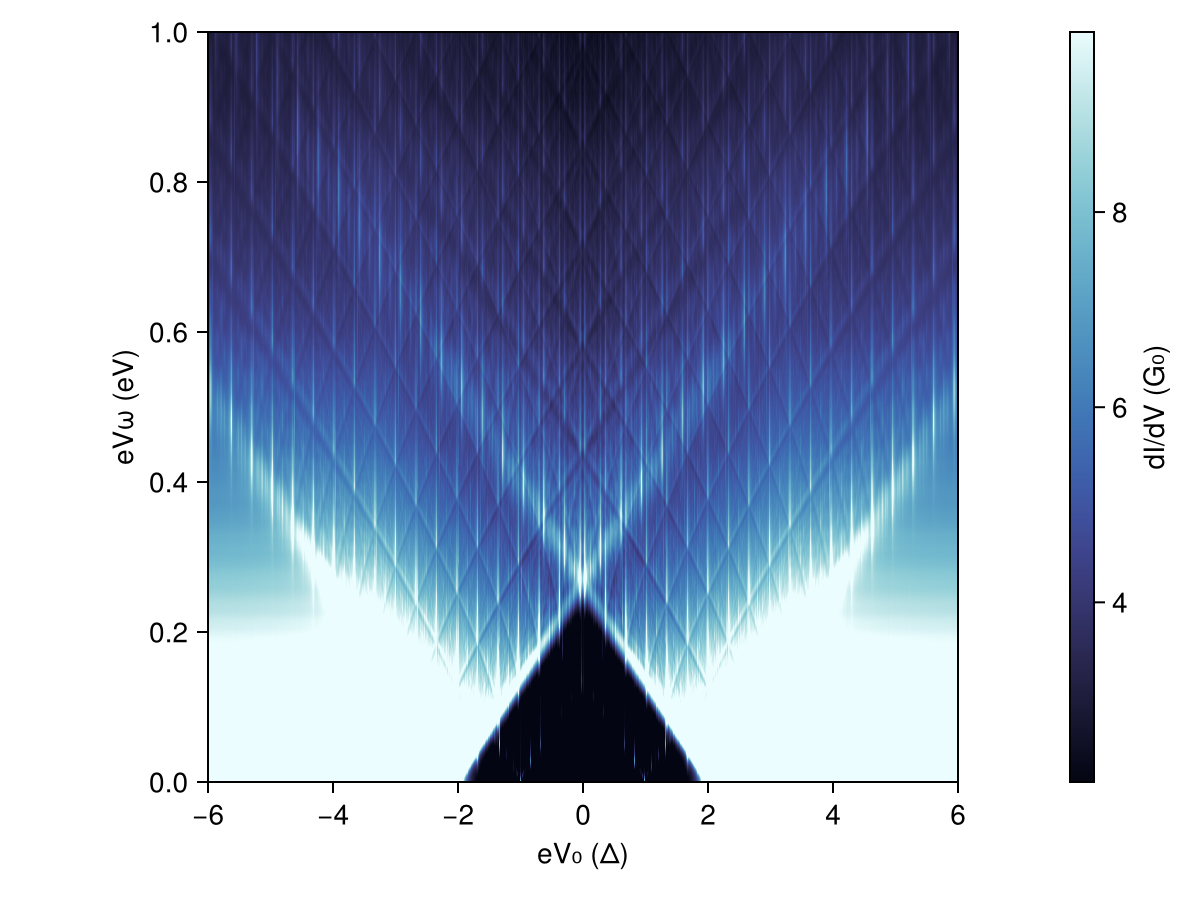

CairoMakie.Screen{IMAGE}


In [5]:
fig = Figure()
ax = Axis(fig[1, 1], aspect=1)

plt = heatmap!(ax, V₀[1:end-1], Vω*0.04, dz, colorrange=clim,colormap=see)
Colorbar(fig[1, 2], plt, label="dI/dV (G₀)")
ax.xlabel = "eV₀ (Δ)"
ax.ylabel = "eVω (eV)"
ax.limits = (V₀[1], V₀[end]), (0.0, 1.0)
ax.yticks = 0:0.2:1.0

display(fig)

In [6]:
save(plotsdir("TG_IV-0.05τ.png"), fig)

In [7]:
function moving_average(data, window)
    out = zeros(length(data))
    for i in 1:length(data)
        if i < window
            out[i] = mean(data[1:i])
        else
            out[i] = mean(data[(i-window+1):i])
        end
    end
    return out
end

moving_average (generic function with 1 method)

In [8]:
function fixer(data)
    # out = zeros(size(data))
    out = copy(data)
    dx = diff(data)
    dx2 = abs.(diff(dx))
    spots = findall(dx2 .> 0.1)
    #interpolate with window around the spikes
    window = 6
    di = Int(round(window / 2))
    for i in spots
        if i > window && i < length(data) - window
            seg = data[(i-di):(i+di)]
            dseg = diff(seg)
            med_seg = median(dseg)
            for j in 1:lastindex(seg)
                out[i+j] = out[i]+ j * med_seg
            end
        else
            out[i] = data[i]
        end
    end

    return out
end

fixer (generic function with 1 method)

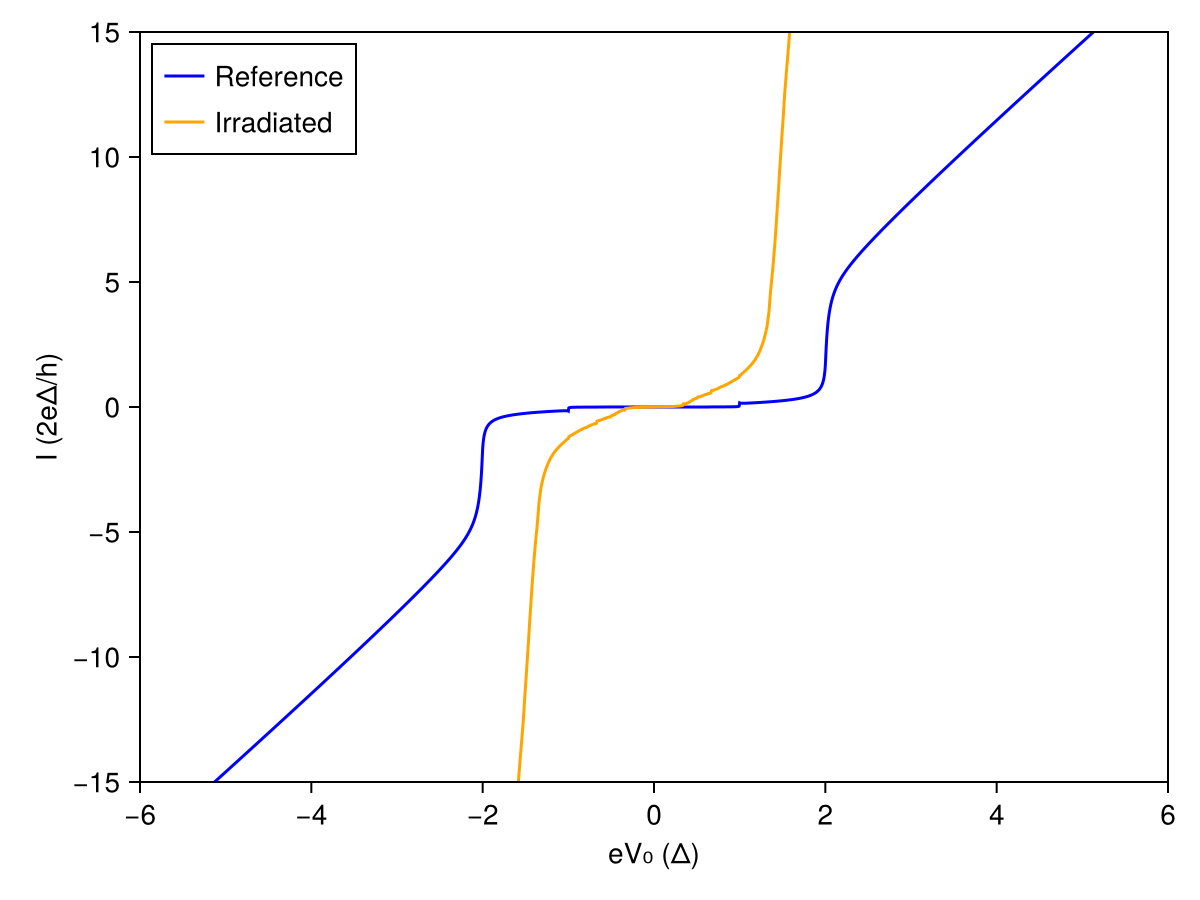

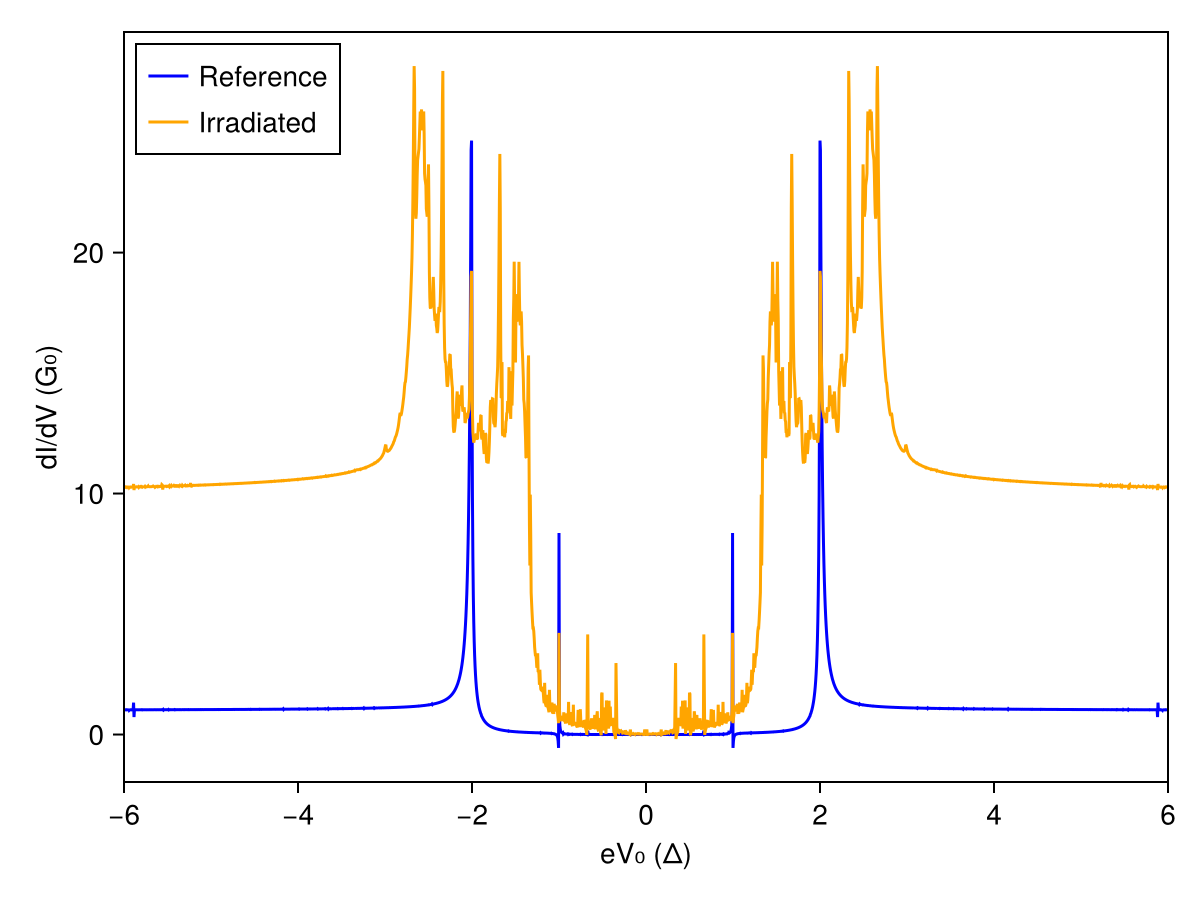

CairoMakie.Screen{IMAGE}


In [9]:
ref_V0, ref_I0 = TG.V0, TG.I0
ref_I0 = fixer(ref_I0)

evolution = 200
fact = 3

fig = Figure()

ax = Axis(fig[1, 1])

lines!(ax, ref_V0, ref_I0*fact, color = :Blue, label = "Reference")
lines!(ax, V₀[1:end], z[:, evolution]*fact, color = :Orange, label = "Irradiated")
axislegend(ax, position=:lt)
ax.ylabel = "I (2eΔ/h)"
ax.xlabel = "eV₀ (Δ)"
xlims!(ax, (-6, 6))
ylims!(ax,(-15, 15))
ax.xgridvisible = false
ax.ygridvisible = false

display(fig)

fig = Figure()

ax = Axis(fig[1, 1])
dy = diff(ref_I0) ./ diff(ref_V0)
lines!(ax, ref_V0[1:end-1], dy, color = :Blue, label = "Reference")
lines!(ax, V₀[1:end-1], dz[:, evolution], color = :Orange, label = "Irradiated")
axislegend(ax, position=:lt)
ax.ylabel = "dI/dV (G₀)"
ax.xlabel = "eV₀ (Δ)"
xlims!(ax, (-6, 6))
ax.xgridvisible = false
ax.ygridvisible = false

# Label(fig[0, 1:2], "PAT @ $(Vω[evolution]) (eV)", fontsize=20)
# Label(fig[0, 1:2], "τ = $(τ)", fontsize=15, padding = (-950, 0, 0, 0))

# ax = Axis(fig[1, 3])
# dy = diff(ref_I0)
# dy2 = abs.(diff(dy))
# lines!(ax, ref_V0[1:end-2], dy2, color = :Red, label = "Reference")
# # lines!(ax, V₀[1:end-2], diff(dz[:, evolution]) ./ diff(V₀[1:end-1]), color = :Blue, label = "Irradiated")
# xlims!(ax, (-6, 6))

display(fig)